In [20]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pprint

from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP, COBYLA, CG
from qiskit.chemistry import QiskitChemistryError
from qiskit.chemistry.applications import MolecularGroundStateEnergy
from qiskit.chemistry.algorithms import ground_state_solvers
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.core import QubitMappingType
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType, HFMethodType

In [11]:
global qubit_mapping
qubit_mapping = 'jordan_wigner'
global two_qubit_reduction
two_qubit_reduction = False
global best_result
global hfmethod
hfmethod = HFMethodType.ROHF
global var_form
global vqe
global ferOp
global shift

In [32]:
backend = Aer.get_backend("statevector_simulator")

optimizer = COBYLA(maxiter=100)
distances = np.arange(0.3, 4, .1)
vqe_energies = []
min = 100.0
dismin = 0.0

for dist in distances:
    charge = 1
    spin = 0
    if dist <= 1.2:
        alt=np.sqrt(dist**2 - (dist/2)**2)
        mol = "H .0 .0 .0; H .0 .0 " + str(dist) + "; H .0 " + str(alt) + " " + str(dist/2)
    else:
        alt=np.sqrt(dist**2 - (0.6)**2)
        mol = "H .0 .0 .0; H .0 .0 0.742; H .0 " + str(alt) + " 0.371"
    driver = PySCFDriver(atom = mol,
                         unit=UnitsType.ANGSTROM, spin = spin,
                         charge=charge, basis='sto-6g',hf_method=hfmethod)
    
    molecule = driver.run()
    
    shift = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_orbitals = molecule.num_orbitals
    num_spin_orbitals = num_orbitals*2
    
    
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    
    qubitOp = ferOp.mapping(map_type=qubit_mapping)
        
    initial_state = HartreeFock(num_spin_orbitals, 
                                num_particles, 
                                qubit_mapping,
                                two_qubit_reduction)
    
    var_form = UCCSD(num_orbitals=num_spin_orbitals,
                        num_particles=num_particles,
                        initial_state=initial_state,
                        qubit_mapping=qubit_mapping,
                        two_qubit_reduction=two_qubit_reduction)
    
    init_parm = np.zeros(var_form.num_parameters)
    vqe = VQE(qubitOp, var_form, optimizer, initial_point=init_parm)
    vqe_result_tot = vqe.run(backend)
    vqe_result = np.real(vqe_result_tot['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    '''
    print("Interatomic Distance:", np.round(dist, 2), 
          "\n\tVQE calculation: ",np.real(vqe_result_tot['eigenvalue']),
          "\n\tNuclear shift: ", shift,                     
          "\n\tVQE Result: ", vqe_result)
    '''
    print("Interatomic Distance:", np.round(dist, 2),"\t VQE result: ", vqe_result)
    if vqe_result < min:
        min = vqe_result
        dismin = dist
        best_result = vqe_result_tot

Interatomic Distance: 0.3 	 VQE result:  0.7930255343076515
Interatomic Distance: 0.4 	 VQE result:  -0.23748110983057558
Interatomic Distance: 0.5 	 VQE result:  -0.7527798382267448
Interatomic Distance: 0.6 	 VQE result:  -1.0251054087899347
Interatomic Distance: 0.7 	 VQE result:  -1.169942571290731
Interatomic Distance: 0.8 	 VQE result:  -1.2433086131598732
Interatomic Distance: 0.9 	 VQE result:  -1.2748265298186463
Interatomic Distance: 1.0 	 VQE result:  -1.281187551306354
Interatomic Distance: 1.1 	 VQE result:  -1.272264503330409
Interatomic Distance: 1.2 	 VQE result:  -1.2572628488744848
Interatomic Distance: 1.3 	 VQE result:  -1.248531587953889
Interatomic Distance: 1.4 	 VQE result:  -1.2370557052088396
Interatomic Distance: 1.5 	 VQE result:  -1.2246482489422787
Interatomic Distance: 1.6 	 VQE result:  -1.2123782569775732
Interatomic Distance: 1.7 	 VQE result:  -1.2008606606256933
Interatomic Distance: 1.8 	 VQE result:  -1.1904922234542925
Interatomic Distance: 1.9 	 

I plot all the calculated energies. It's clearly visible an absolute minimum

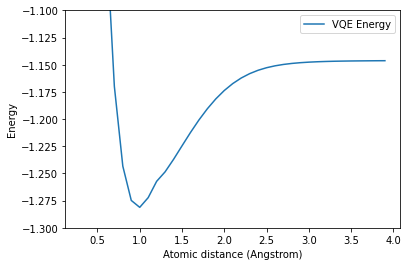

In [31]:
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.ylim([-1.3, -1.10])
plt.show()

### More VQE information

Printing all informations, parameter values, eigenalues (ecc. ecc.) for the best iteration of the VQE algorithm (bond length). 

In [33]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(best_result)

{   'cost_function_evals': 100,
    'eigenstate': array([-2.47072544e-17-2.50503678e-17j, -5.13587650e-16+1.04762132e-15j,
        9.74250767e-17+5.84305589e-18j,  6.75299668e-17-8.71818926e-17j,
        7.42656242e-17-3.18796931e-17j,  1.34184990e-16+4.71483953e-17j,
        6.35855735e-17-1.03800576e-16j,  2.00134432e-17+3.05985502e-17j,
       -2.64290994e-16+9.36105182e-16j,  9.90361790e-01-7.75315393e-15j,
       -2.12957491e-04-1.54045816e-16j,  4.70628360e-16+6.17301404e-16j,
        3.50948029e-04+2.04718185e-16j,  3.51860912e-16+6.17390369e-16j,
       -4.88322697e-17+1.04572445e-16j,  6.09134065e-17-7.97906743e-17j,
        1.81634892e-17-6.17090616e-17j,  5.72932921e-04+9.77725394e-17j,
       -9.80310810e-02+5.14093087e-16j, -2.53132680e-17-1.33344399e-16j,
       -4.54211857e-05-3.45382068e-17j,  3.28055215e-17-7.87451973e-18j,
       -4.20754521e-17-6.06443049e-17j, -7.40850207e-17-8.26667500e-19j,
        4.17064836e-17-3.57640637e-17j,  4.76012098e-16+5.59087371e-16j,
 

H3+ hamiltonian, qubit mapped and simplified.

In [34]:
pp.pprint(ferOp.mapping(qubit_mapping).simplify().print_details())

('IIIIII\t(-1.3710914596000712+0j)\n'
 'IIIIIZ\t(0.1729921938896205+0j)\n'
 'IIIIYY\t(0.0008990120420158368+0j)\n'
 'IIIIXX\t(0.0008990120420158368+0j)\n'
 'IIIIZI\t(0.04214794823912783+0j)\n'
 'IIIZII\t(-0.2210365842753662+0j)\n'
 'IIZIII\t(0.1729921938896204+0j)\n'
 'IYYIII\t(0.0008990120420158353+0j)\n'
 'IXXIII\t(0.0008990120420158353+0j)\n'
 'IZIIII\t(0.04214794823912789+0j)\n'
 'ZIIIII\t(-0.22103658427536618+0j)\n'
 'IIIIZZ\t(0.034221120216452454+0j)\n'
 'IIIZIZ\t(0.12058531852223081+0j)\n'
 'IIIZYY\t(0.0013731770918290144+0j)\n'
 'IIIZXX\t(0.0013731770918290144+0j)\n'
 'IIZIIZ\t(0.1685123267806977+0j)\n'
 'IIZIYY\t(0.0021623381850934026+0j)\n'
 'IIZIXX\t(0.0021623381850934026+0j)\n'
 'IXXIIZ\t(0.0021623381850934026+0j)\n'
 'IYYIIZ\t(0.0021623381850934026+0j)\n'
 'IXXIYY\t(6.706703281803655e-05+0j)\n'
 'IYYIYY\t(6.706703281803655e-05+0j)\n'
 'IXXIXX\t(6.706703281803655e-05+0j)\n'
 'IYYIXX\t(6.706703281803655e-05+0j)\n'
 'XZXYZY\t(0.04539056492862682+0j)\n'
 'YZYYZY\t(0.0453905649

UCCSD variational form just considers these single and double excitations (spin and number of particles conservation):

In [35]:
print(var_form.single_excitations)
print(var_form.double_excitations)

[[0, 1], [0, 2], [3, 4], [3, 5]]
[[0, 1, 3, 4], [0, 1, 3, 5], [0, 2, 3, 4], [0, 2, 3, 5]]


## Exact solution

In [77]:
from qiskit.aqua.algorithms import NumPyEigensolver
from qiskit.chemistry.core import Hamiltonian
from qiskit.chemistry.core import QubitMappingType, TransformationType
from qiskit.chemistry.drivers import PySCFDriver, UnitsType

basis_string = 'sto-6g'
dist = 1
alt=np.sqrt(dist**2 - (dist/2)**2)
molecule_string = "H .0 .0 .0; H .0 .0 " + str(dist) + "; H .0 " + str(alt) + " " + str(dist/2)
charge = 1

driver = PySCFDriver(atom=molecule_string, charge=charge, unit=UnitsType.ANGSTROM, basis=basis_string)
molecule = driver.run()

core = Hamiltonian(transformation=TransformationType.FULL, qubit_mapping=QubitMappingType.JORDAN_WIGNER, 
                   two_qubit_reduction=False, freeze_core=False)

qubit_op, aux_ops = core.run(molecule)

algo = NumPyEigensolver(qubit_op, k=6, aux_operators=aux_ops)
res = algo.run()

lines, result = core.process_algorithm_result(res)
print(*lines, sep='\n')

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -2.964867626005
  - computed part:      -2.964867626005
  - frozen energy part: 0.0
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 1.58753163276
> Total ground state energy (Hartree): -1.377335993245
  Measured:: Num particles: 3.000, S: 0.500, M: -0.19173
 
=== EXCITED STATES ===
 
> Excited states energies (plus ground): [-1.377335993245, -1.377335993245, -1.377335993245, -1.377335993245, -1.281187999425, -0.988743597084]
    - computed: [-2.964867626005, -2.964867626005, -2.964867626005, -2.964867626005, -2.868719632185, -2.576275229844]
  ......................................................................
  ###:  Total Energy,      Computed,       # particles,   S         M
    0:  -1.377335993245,  -2.964867626005,     3.000,   0.500,  -0.19173
    1:  -1.377335993245,  -2.964867626005,     3.000,   0.500,   0.09464
    2:  -1.377335993245,  -2.964867626005,     3.000,   0.500,   0.0645